<a href="https://colab.research.google.com/github/felixsimard/comp551-p2/blob/main/P2_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Part 1: Optimization (80 points)**

## Setup

In [ ]:
# append the folder to the path
import sys
folder = '/content/drive/MyDrive/COMP551/mini2/'
if folder not in sys.path:
  sys.path.append(folder)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import time
import pandas as pd
import numpy as np
import os
import joblib
import random

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel, delayed
from sklearn.metrics import accuracy_score

# Additional Python files
from LogisticRegression import LogisticRegression, TrainingResults
from Gradient import *
LogisticRegression.gradient = gradient

In [ ]:
# Define datasets paths
diabetes_train_dir = '/content/drive/MyDrive/COMP551/mini2/diabetes/diabetes_train.csv'
diabetes_val_dir = '/content/drive/MyDrive/COMP551/mini2/diabetes/diabetes_val.csv'
diabetes_test_dir = r'/content/drive/MyDrive/COMP551/mini2/diabetes/diabetes_test.csv'

diabetes_train_df = pd.read_csv(diabetes_train_dir, engine="python", error_bad_lines=False)
diabetes_val_df = pd.read_csv(diabetes_val_dir, engine="python", error_bad_lines=False)
diabetes_test_df = pd.read_csv(diabetes_test_dir, engine="python", error_bad_lines=False)

## Feature-Target split

In [ ]:
# split into feature and target
diabetes_train_X =  diabetes_train_df.drop('Outcome', axis=1)
diabetes_train_y = diabetes_train_df.loc[:, 'Outcome']
diabetes_val_X = diabetes_val_df.drop('Outcome', axis=1)
diabetes_val_y = diabetes_val_df.loc[:, 'Outcome']
diabetes_test_X = diabetes_test_df.drop('Outcome', axis=1)
diabetes_test_y = diabetes_test_df.loc[:, 'Outcome']

## 3. Momentum
Add momentum to the gradient descent implementation. Trying multiple values for the momentum coefficient, how does it compare to regular gradient descent ? Specifically, analyze the impact of momentum on the conver- gence speed and the quality of the final solution.

In [ ]:
def get_result(lr, max_iters=2e4, itv=1e2,
               batch_size=-1, max_epochs=-1, momentum=0, smoothing=False):
    model = LogisticRegression(verbose=True, learning_rate=lr, max_iters=max_iters)
    result = model.fit_for_vis_complex2(diabetes_train_X, diabetes_train_y, diabetes_val_X, diabetes_val_y,
                                       itv, batch_size, max_epochs, momentum, smoothing)
    return result

def get_test_acc(result, test_X, test_y):
    model = result.lr_model
    test_yh = (model.predict(test_X) > 0.5).astype('int')
    return accuracy_score(test_y, test_yh)

In [ ]:
# base configuration
itv = int(1e2)
lr = 1e-4
max_iters = 2e4

###Convergence speed in batch gradient descent

In [ ]:
%%time
full_batch_result = get_result(lr, max_epochs=max_iters, itv=itv, momentum=0)
full_batch_grad = full_batch_result.grad_list_it

(600, 9)
1000/20000.0 complete.
2000/20000.0 complete.
3000/20000.0 complete.
4000/20000.0 complete.
5000/20000.0 complete.
6000/20000.0 complete.
7000/20000.0 complete.
8000/20000.0 complete.
9000/20000.0 complete.
10000/20000.0 complete.
11000/20000.0 complete.
12000/20000.0 complete.
13000/20000.0 complete.
14000/20000.0 complete.
15000/20000.0 complete.
16000/20000.0 complete.
17000/20000.0 complete.
18000/20000.0 complete.
19000/20000.0 complete.
20000/20000.0 complete.
learning rate: 0.0001
batch size: 600
terminated after 20000 iterations, with norm of the gradient equal to 0.03688797641062749
the weight found: [ 0.12707092  0.01360153 -0.03072391 -0.00098248  0.00157526 -0.00516213
  0.01310926 -0.0114703  -0.07150881]
time elapsed:  20.02 seconds

CPU times: user 19.9 s, sys: 159 ms, total: 20 s
Wall time: 20 s


In [ ]:
full_batch_grad = full_batch_result.grad_list_epoch

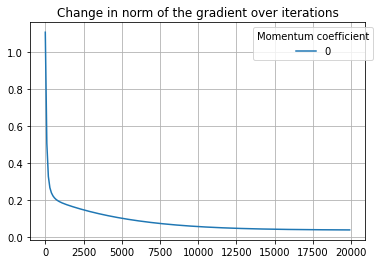

In [ ]:
# Create plot
length = len(full_batch_grad)
row = list(range(1, length*itv, itv))
plt.plot(row, full_batch_grad)
plt.legend(['0'], bbox_to_anchor=(1.04,1),
           title='Momentum coefficient')
plt.grid()
plt.title("Change in norm of the gradient over iterations")
plt.savefig('/content/drive/MyDrive/COMP551/mini2/figures/1_3_batch_grad.png', bbox_inches="tight")
plt.show()

### Try different momentum coefficients

In [ ]:
%%time
# Momentum added to LogisticRegression.py fit_for_vis_complex function
# base configuration
itv = int(1e2)
lr = 1e-4
max_iters = 2e4
coeffs = [0, 0.2, 0.5, 0.7, 0.9, 0.99]
momentum_results = Parallel(n_jobs=-1, verbose=10)(delayed(get_result)(lr, max_iters, itv, momentum=coeff) for coeff in coeffs)
momentum_grads = [r.grad_list_it for r in momentum_results]
momentum_accs = [r.acc_list_it for r in momentum_results]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:   19.4s remaining:    9.7s


CPU times: user 192 ms, sys: 52.1 ms, total: 244 ms
Wall time: 28.4 s


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   28.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   28.4s finished


In [ ]:
[get_test_acc(result, diabetes_test_X, diabetes_test_y) for result in momentum_results]

[0.7205882352941176,
 0.7205882352941176,
 0.7205882352941176,
 0.7205882352941176,
 0.7205882352941176,
 0.7205882352941176]

Text(0.5, 1.0, 'Change in norm of the gradient over iterations')

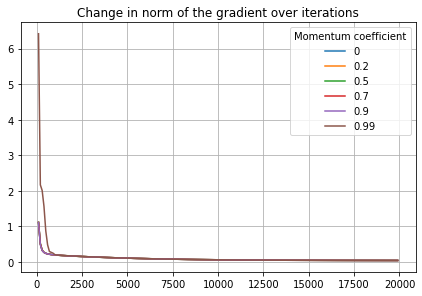

In [ ]:
# Create plot
my_list = momentum_grads
length = len(my_list[0])
row = list(range(1, length*itv, itv))
[plt.plot(row, my_list[i]) for i in range(len(my_list))]
plt.legend(['0', '0.2', '0.5', '0.7', '0.9', '0.99'],
           title='Momentum coefficient')
plt.grid()
plt.tight_layout()
plt.title("Change in norm of the gradient over iterations")
#plt.savefig('/content/drive/MyDrive/COMP551/mini2/figures/1_3_mom_grads.png')

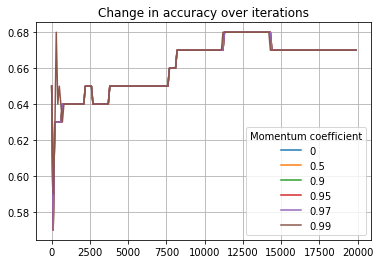

In [ ]:
# Create plot
my_list = momentum_accs
length = len(my_list[0])
row = list(range(1, length*itv, itv))
[plt.plot(row, my_list[i]) for i in range(len(my_list))]
plt.legend(['0', '0.5', '0.9', '0.95', '0.97', '0.99'],
           title='Momentum coefficient')
plt.grid()
plt.title("Change in accuracy over iterations")
#plt.savefig('/content/drive/MyDrive/COMP551/mini2/figures/1_3_mom_accs.png')

## 4. Experiment momentum with mini-batch SGD
repeat the previous step for a) the smallest batch size and b) largest batch size you tried in 2). In which setting (small mini-batch, large mini-batch, fully batched) is it the most / least effective ?

#####Smallest mini-batch: `batch_size`=8

In [ ]:
import random
import joblib

In [ ]:
%%time
# Momentum added to LogisticRegression.py fit_for_vis_complex function
# base configuration
itv = int(1e2)
lr = 1e-4
max_iters = 2e4
coeffs = [0, 0.2, 0.5, 0.7, 0.9, 0.99]
mini_small_results = Parallel(n_jobs=-1, verbose=10)(delayed(get_result)(lr,max_iters, itv,
                                                                       batch_size=8, max_epochs=max_iters, momentum=coeff) for coeff in coeffs)
#joblib.dump(mini_small_results, '/content/drive/MyDrive/COMP551/mini2/objects/mini_small_results.pkl')

In [ ]:
mini_small_results = joblib.load('/content/drive/MyDrive/COMP551/mini2/objects/mini_small_results.pkl')
[get_test_acc(result, diabetes_test_X, diabetes_test_y) for result in mini_small_results]

[0.7352941176470589,
 0.7647058823529411,
 0.7352941176470589,
 0.75,
 0.7647058823529411,
 0.7058823529411765]

In [ ]:
def save_plot(input_result, lr, grad=True, bs='bs8'):
    # Create plot
    if grad:
        my_list = input_result.grad_list_epoch
        plt_title = 'norm of the gradient'
    else:
        my_list = input_result.acc_list_epoch
        plt_title = 'accuracy'
    length = len(my_list)
    row = list(range(1, length*itv, itv))
    plt.plot(row, my_list)
    plt.legend([str(lr)], bbox_to_anchor=(1.04,1),
            title='Momentum coefficient')
    plt.grid()
    plt.title("Change in " + plt_title + " over epochs")
    #plt.savefig(f"{'/content/drive/MyDrive/COMP551/mini2/figures/1_3_' + bs + '_mini_grad_coeff0'+ str(int(lr*100)) + '.png'}", bbox_inches="tight")
    plt.show()


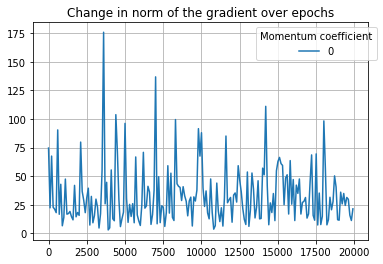

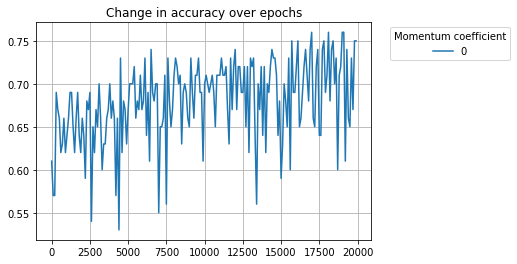

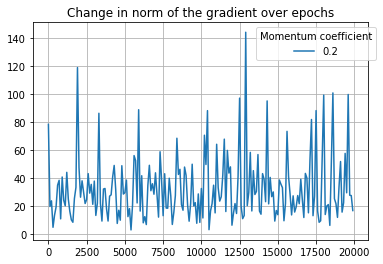

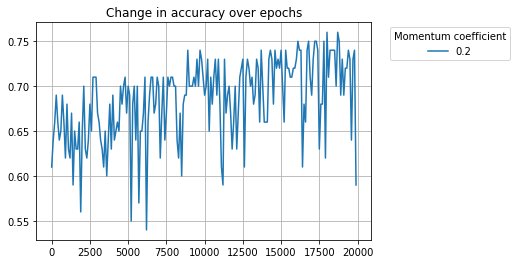

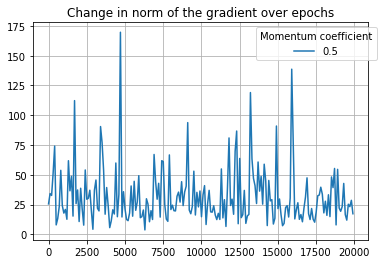

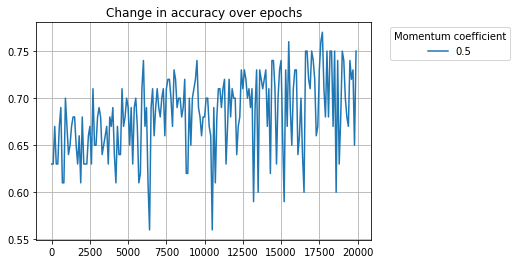

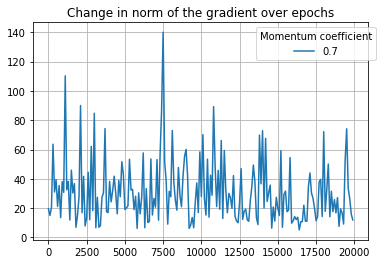

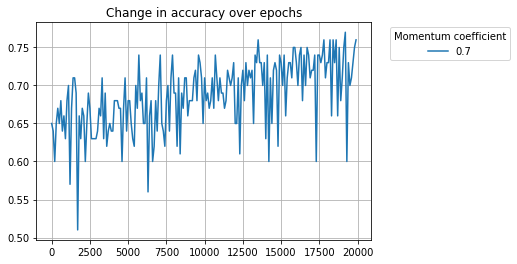

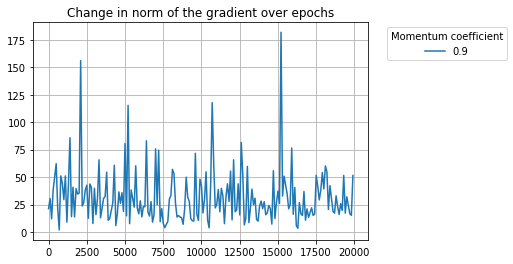

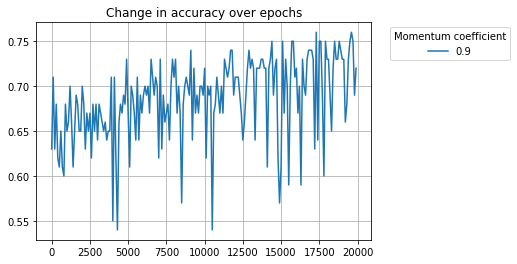

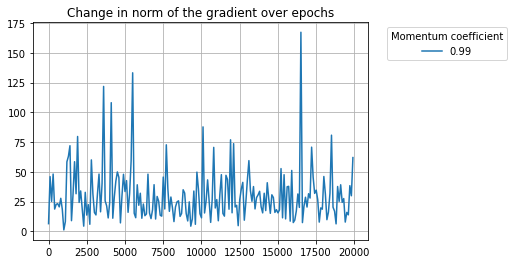

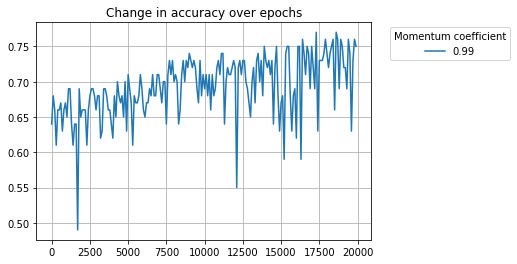

In [ ]:
for result, lr in zip(mini_small_results, [0, 0.2, 0.5, 0.7, 0.9, 0.99]):
    save_plot(result, lr, grad=True, bs='bs8')
    save_plot(result, lr, grad=False, bs='bs8')

####Largest mini-batch: `batch_size`=512

In [ ]:
%%time
# Momentum added to LogisticRegression.py fit_for_vis_complex function
# base configuration
itv = int(1e2)
lr = 1e4
max_iters = 2e4
coeffs = [0, 0.2, 0.5, 0.7, 0.9, 0.99]
mini_large_results = Parallel(n_jobs=-1, verbose=10)(delayed(get_result)(lr,max_iters, itv,
                                                                       batch_size=512, max_epochs=max_iters,
                                                                       momentum=coeff, smoothing=True) for coeff in coeffs)
#joblib.dump(mini_large_results, '/content/drive/MyDrive/COMP551/mini2/objects/mini_large_results.pkl')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   35.5s remaining:    0.0s


KeyboardInterrupt: ignored

In [ ]:
[get_test_acc(result, diabetes_test_X, diabetes_test_y) for result in mini_large_results]

[0.7058823529411765,
 0.7205882352941176,
 0.7205882352941176,
 0.7205882352941176,
 0.6911764705882353,
 0.7205882352941176]

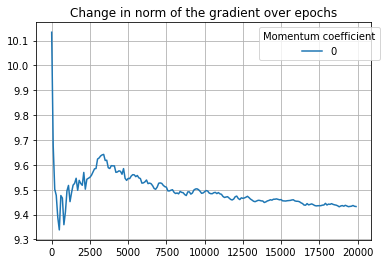

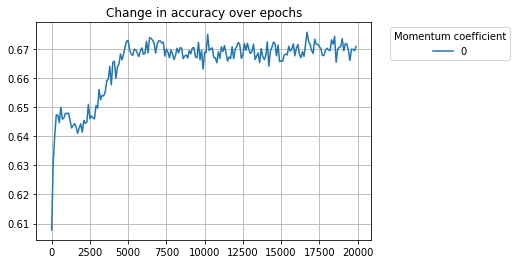

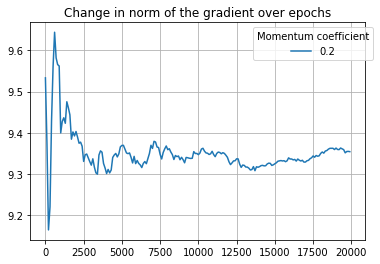

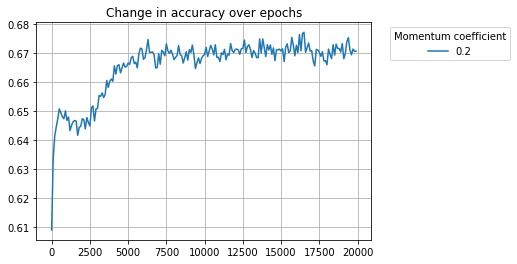

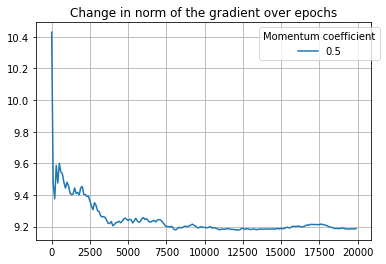

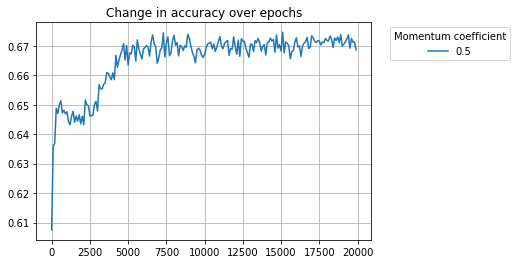

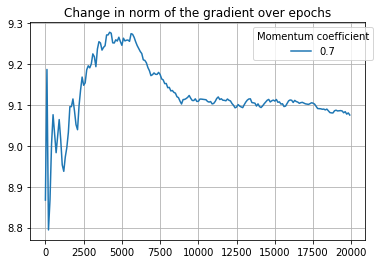

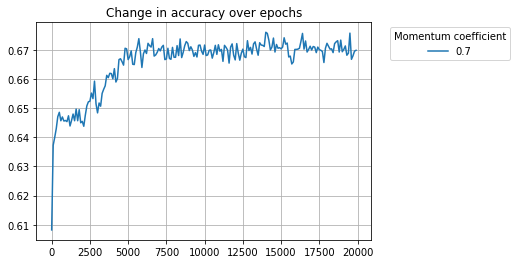

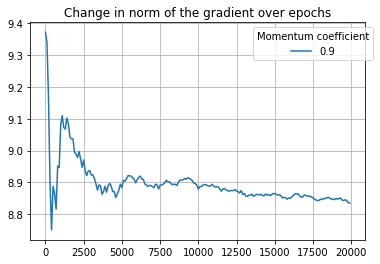

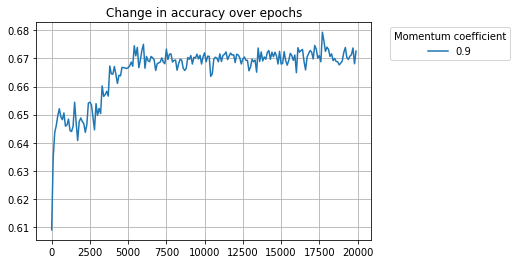

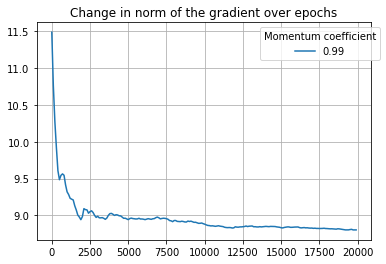

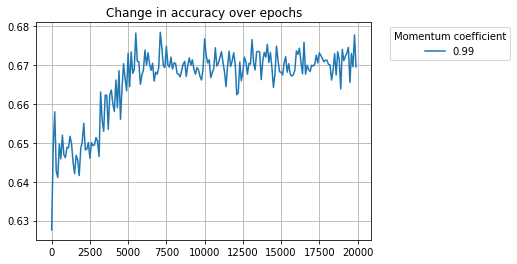

In [ ]:
for result, lr in zip(mini_large_results, [0, 0.2, 0.5, 0.7, 0.9, 0.99]):
    save_plot(result, lr, grad=True, bs='bs512')
    save_plot(result, lr, grad=False, bs='bs512')

###Batch gradient descent



In [17]:
%%time
# Momentum added to LogisticRegression.py fit_for_vis_complex function
# base configuration
itv = int(1e2)
lr = 1e-4
max_iters = 2e4
coeffs = [0, 0.2, 0.5, 0.7, 0.9, 0.99]
full_results = Parallel(n_jobs=-1, verbose=10)(delayed(get_result)(lr,max_iters, itv,
                                                                       batch_size=600, max_epochs=max_iters, momentum=coeff, smoothing=True) for coeff in coeffs)
#joblib.dump(mini_small_results, '/content/drive/MyDrive/COMP551/mini2/objects/batch_results.pkl')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:  1.1min remaining:   33.1s


CPU times: user 376 ms, sys: 46.9 ms, total: 423 ms
Wall time: 1min 38s


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  1.6min finished


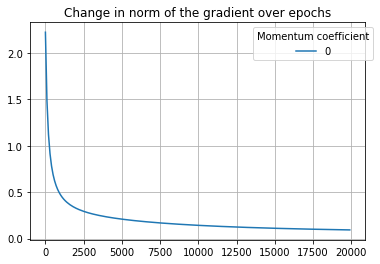

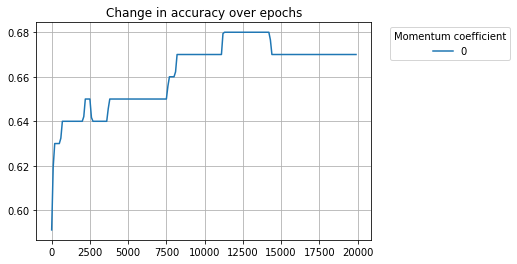

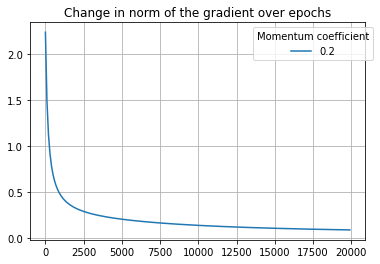

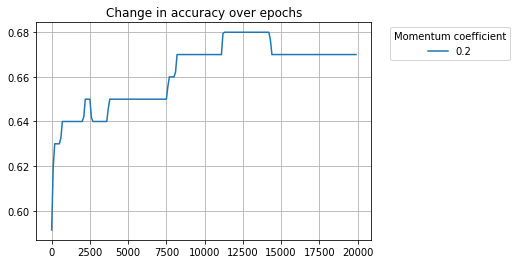

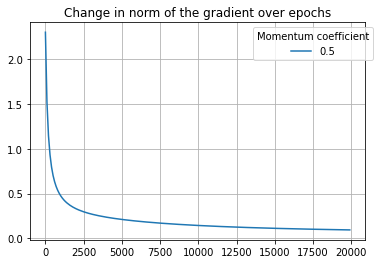

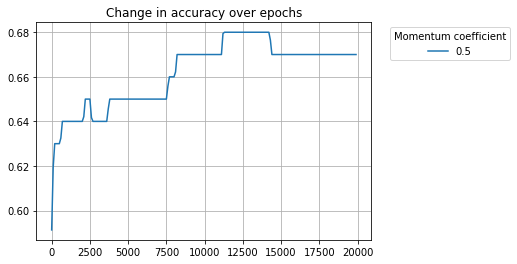

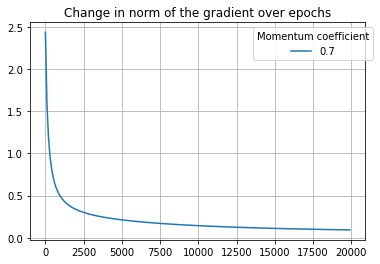

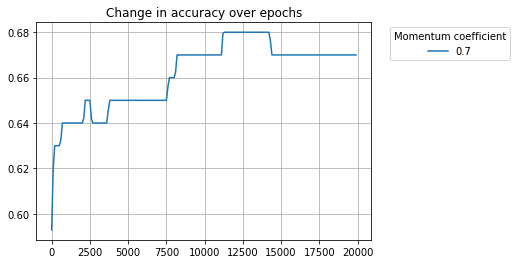

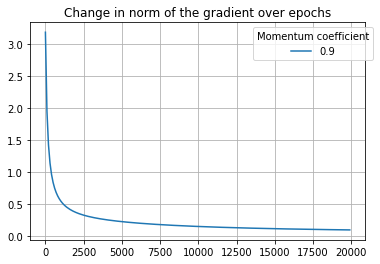

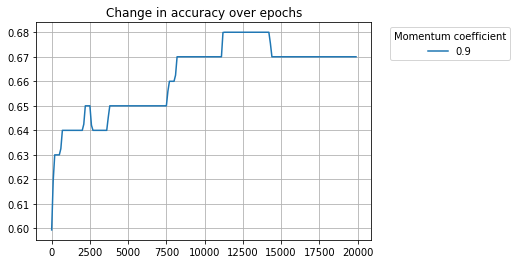

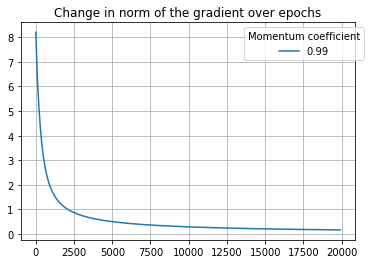

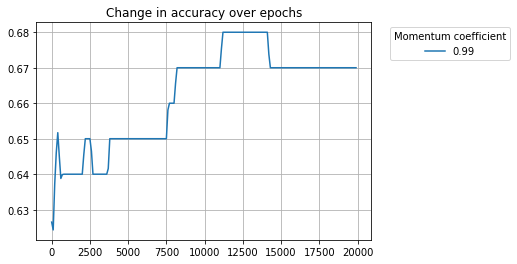

In [18]:
for result, lr in zip(full_results, [0, 0.2, 0.5, 0.7, 0.9, 0.99]):
    save_plot(result, lr, grad=True, bs='full')
    save_plot(result, lr, grad=False, bs='full')